# Width algorithm

In [1]:
import glob,os,cv2,math
import numpy as np
from skimage import morphology,feature, draw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from DSE_prune import *
from intersection_remover import *
from rasterizing import *

In [2]:
def get_pca_vector(skeleton_region,verbose=False):
    """
    This function uses principal component analysis to determine the orientation of the skeletion region. 
    Every point in the skeleton region is represented by (r,c) but can be represented by (0,r/c) instead by compressing the data.
    The orientation can be found by obtaining the largest eigenvalue corresponding to the eigenvector of the covariance matrix.
    Arguments:
    skeleton_region - a small region of the skeleton.
    
    Return:
    v - local orthogonal basis vector
    """
    
    row, column = np.nonzero(skeleton_region)
    row = sorted(row[np.newaxis,:])
    column = sorted(column[np.newaxis,:])
    data_pts = np.concatenate((row,column),axis = 0).T.astype(np.float64)
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts,mean)
    
    angle = math.atan2(eigenvectors[0,0], eigenvectors[0,1]) * 180 / math.pi # orientation in degrees 
    if verbose:
        print(f"The data points are {data_pts}")
        print(f"The eigenvalues are{eigenvalues}")
        print(f"The eigenvectors are {eigenvectors}")
        print(f"The principal vector angle is {angle}")
    try:
        v = np.asarray([eigenvectors[1,0],eigenvectors[1,1]])
    except IndexError:
        v = []
    return v

In [3]:
def get_constant_region_pca(coord,skeleton,verbose=False):
    """
    This function the orientation using a constant kernel (5x5)
    The output kernel has 2 assumptions:
    (1) Kernel is a square
    (2) Kernel is size is odd i.e. 5x5, 7x7 and so on
    Arguments:
    coord - coordinates of point of interest
    skeleton - the skeleton of the image, obtained by using medial axis transform / thinning / dse and etc
    diff - difference in error between iterations
    
    Return:
    gradient - the gradient at the point of interest
    """
    kernel_size = 5 # Initialize kernel size to be 7x7
    r,c = coord
    max_r ,max_c = skeleton.shape
    angle_1 = angle_2 = 0 # Initialize grad_1 to be gradient at i-1
    eps = 1e-8
    index = 0
    
    width = height = kernel_size // 2        
    skeleton_region = skeleton[r-height:r+height+1,c-width:c+width+1] # gets the skeleton region      
    v = get_pca_vector(skeleton_region,verbose)
    
    return v

In [4]:
def get_adaptive_region_pca(coord,skeleton,diff=0.01,verbose=False):
    """
    This function returns an appropriate sized kernel such that the gradient at the point of interest already converges. 
    The output kernel has 2 assumptions:
    (1) Kernel is a square
    (2) Kernel is size is odd i.e. 5x5, 7x7 and so on
    Arguments:
    coord - coordinates of point of interest
    skeleton - the skeleton of the image, obtained by using medial axis transform / thinning / dse and etc
    diff - difference in error between iterations
    
    Return:
    gradient - the gradient at the point of interest
    """
    kernel_size = 5 # Initialize kernel size to be 3x3
    r,c = coord
    max_r ,max_c = skeleton.shape
    angle_1 = angle_2 = 0 # Initialize grad_1 to be gradient at i-1
    eps = 1e-8
    index = 0
    while True:      
        width = height = kernel_size // 2        
        # Handle edge cases
        if r-width < 0 or r+width > max_r or c-height < 0 or c+height > max_c:
            return v
        
        skeleton_region = skeleton[r-height:r+height+1,c-width:c+width+1] # gets the skeleton region      
        v = get_pca_vector(skeleton_region,verbose)
        if len(v) > 0:
            angle_2 = math.atan2(v[0], v[1]) * 180 / math.pi # orientation in degrees 
        else:
            return []
        
        if verbose:
            plt.figure()
            plt.imshow(skeleton_region,origin="lower")
            print(f"The orthogonal angle is {angle_2}")
            
        grad_rel_error = abs((angle_1-angle_2)/(angle_1+eps))

        if grad_rel_error < diff and index > 0:
            return v
        
        angle_1 = angle_2
        kernel_size += 2
        index += 1

In [5]:
def binarize(mask):
    """
    This function takes in the input mask in RGB and converts it to binary output.
    This assumes that the mask has a shape of (H,W,C) where channel is in the dimension 2
    Arguments:
    mask: your mask, input in numpy
    
    Return: 
    binary_mask: binary mask where 0 = background
                                   1 = crack
    """
    mask[mask > 0] = 1
    mask = np.any(mask,axis = 2)

    return mask

In [6]:
def get_width(pois,dt,bin_img,S,B,b,verbose = False,visualize=False):
    """
    This function calculates the width using the Euclidean distance between two points.
    To obtain the two points, we obtain the projection value based on the orthonormal vector, v.
    
    Arguments:
    poi (array) - point of interests
    dt (np.array) - distance transform
    bin_img - removed intersection of binary image
    S (np.array) - the skeleton image
    B (np.array) - the boundary image
    b (list) - original boundary coordinates
    verbose (bool) - print information
    
    Return:
    distance - the Euclidean distance between the 2 points
    """
    img = np.reshape((S+B),(*B.shape,1))
    img = np.concatenate([img,img,img],axis=-1)*255
    r_b, c_b = np.nonzero(B.astype(np.int))
    boundary_pts = list(zip(r_b,c_b))
    collision_pts = list(set(pois) & set(boundary_pts))    
    _, labels_bin_img = cv2.connectedComponents(bin_img)

    for poi in pois:
        temp_max = temp_min = 0
        collision = False
        r_p, c_p = poi
        radius = max(dt[r_p,c_p]*2,6)
        onb = get_adaptive_region_pca(poi,S,verbose=verbose)
        
        if len(onb) == 0:
            distance = 0
            continue
        
        poi_vector = np.asarray(poi)
        label = labels_bin_img[r_p,c_p]
        sub_canny = feature.canny(labels_bin_img == label)
        r_b_sub, c_b_sub = np.nonzero(sub_canny)
        boundary_pts_sub = list(zip(r_b_sub,c_b_sub))
        B_matrix = np.asarray(boundary_pts_sub)
        if poi in boundary_pts_sub:
            collision = True
            index = np.where(np.all(B_matrix == poi_vector,axis = 1))
            B_matrix = np.delete(B_matrix,index,axis=0)
            
        B_prime = B_matrix - poi_vector
        B_prime_dist_mask = np.linalg.norm(B_prime,axis=1) < radius # Apply threshold to search only local vicinity
            
        # Apply double mask to B_matrix, just like covid-19. Double mask ensures safety. Double mask here ensures
        # that the B_matrix corresponds to the correct points
        B_matrix = B_matrix[B_prime_dist_mask]
        B_prime = B_prime[B_prime_dist_mask]
        B_prime_norm = B_prime / np.linalg.norm(B_prime,axis=1,keepdims=True)
        projection_coeff = np.matmul(B_prime_norm,onb.T)
        projection_coeff_mask = projection_coeff != 0
        projection_coeff = projection_coeff[projection_coeff_mask]
        B_matrix = B_matrix[projection_coeff_mask]

        max_val = max(projection_coeff) 
        min_val = min(projection_coeff) 
        constant = 0.99
        
        # Checks if shortest point exceeds 3 times
        while True:
            num_pts_1 = B_matrix[np.nonzero(projection_coeff / (max_val) > constant)]
            num_pts_2 = B_matrix[np.nonzero(projection_coeff / (min_val) > constant)]

            dist_1 = dist_2 = float("inf")
            pt1 = pt2 = None
            for pts_1 in num_pts_1:
                temp_dist = np.linalg.norm(pts_1-poi_vector)
                if temp_dist < dist_1:
                    pt1 = pts_1
                    dist_1 = temp_dist

            for pts_2 in num_pts_2:
                temp_dist = np.linalg.norm(pts_2-poi_vector)
                if temp_dist < dist_2:
                    pt2 = pts_2
                    dist_2 = temp_dist
            
            r0, c0 = pt1
            r1, c1 = pt2
            rr, cc = draw.line(r0,c0,r1,c1)
            line_pts = list(zip(rr,cc))
            num_intersections = list(set(line_pts) & set(boundary_pts_sub))
            if constant < 0.95 or len(num_intersections) <= 2:
                break
            elif len(num_intersections) > 2:
                constant -= 0.01

        # Check for possibility of unbounded skeleton points 
        if collision:
            max_point = B_matrix[np.argmax(projection_coeff)]
            min_point = B_matrix[np.argmin(projection_coeff)]
            two_pts = [max_point,min_point]
            pts = np.asarray([max_point,min_point])
            dist = np.linalg.norm(pts-poi_vector,axis=1)
            min_dist_index = np.argmin(dist)
            dist_1 = 0
            dist_2 = dist[min_dist_index]
            pt1 = poi_vector
            pt2 = two_pts[min_dist_index]
        
        if verbose: 
            print(f"Projection coefffictient max : {np.max(projection_coeff)}")
            print(f"Projection coefffictient min : {np.min(projection_coeff)}")
            print(f"Projection coefffictient argmax : {np.argmax(projection_coeff)}")
            print(f"Projection coefffictient argmin : {np.argmin(projection_coeff)}")
            print(f"Number of candidate points for p1 {(num_pts_1)}")
            print(f"Number of candidate points for p2 {(num_pts_2)}")

        if visualize:
            color = (0,255,0) # Line color
            start_pt = (pt1[1],pt1[0]) 
            end_pt = (pt2[1],pt2[0]) # points used in the library are inverted
            img = cv2.line(img,start_pt,(poi[1],poi[0]),color,1)    
            img = cv2.line(img,end_pt,(poi[1],poi[0]),color,1)    

            distance = dist_1 + dist_2
    
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    return distance, img

In [7]:
def get_width_brute(poi,S,B,verbose = False,visualize=False):
    """
    This function calculates the width using the Euclidean distance between two points.
    To obtain the two points, we obtain the projection value based on the orthonormal vector, v.
    
    Arguments:
    poi (tuple) - point of interest
    S (np.array) - the skeleton image
    B (np.array) - the boundary image
    verbose (bool) - print information
    
    Return:
    distance - the Euclidean distance between the 2 points
    """
    img = None
    onb = get_constant_region_pca(poi,S,verbose=False)
    poi_vector = np.asarray(poi)
    r_b, c_b = np.nonzero(B)
    B_matrix = np.asarray(list(zip(r_b,c_b)))

    if poi_vector in B_matrix:
        index = np.where(np.all(B_matrix == poi_vector,axis = 1))
        B_matrix = np.delete(B_matrix,index,axis=0)
    
    B_prime = B_matrix - poi_vector
    B_prime_norm = B_prime / np.linalg.norm(B_prime,axis=1,keepdims=True)
    projection_coeff = np.matmul(B_prime_norm,onb.T)
    max_pos = np.argmax(projection_coeff)
    min_pos = np.argmin(projection_coeff)
    distance = np.linalg.norm(B_matrix[max_pos] - B_matrix[min_pos])
    
    if verbose: 
        print(f"Number of boundary points {len(B_matrix)}")
        print(f"Number of skeleton poitns {len(S)}")
        print(f"Number of candidate points for p1 {(B_matrix[num_pts_1])}")
        print(f"Number of candidate points for p2 {(B_matrix[num_pts_2])}")
        
    if visualize:
        img = np.reshape((S+B),(*B.shape,1))
        img = np.concatenate([img,img,img],axis=-1)
        color = (0,255,0) # Line color
        start_pt = (B_matrix[max_pos][1],B_matrix[max_pos][0]) 
        end_pt = (B_matrix[min_pos][1],B_matrix[min_pos][0]) # points used in the library are inverted
        
        img = cv2.line(img*255,start_pt,(poi[1],poi[0]),color,1)
        img = cv2.line(img*255,end_pt,(poi[1],poi[0]),color,1)
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        
        
    print(f"Final point 1 : {B_matrix[max_pos]}, Final point 2 :{B_matrix[min_pos]}")    
    return distance, img

# Test cases

In [8]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.figure()
    plt.imshow(labeled_img)

The nodes are [1, 3, 4, 5, 7, 8, 10, 11, 13, 17]
The degree corresponding to each node is [3]
The points that have deg more than 2 are [array([177.66666667, 188.33333333])]
skeleton points


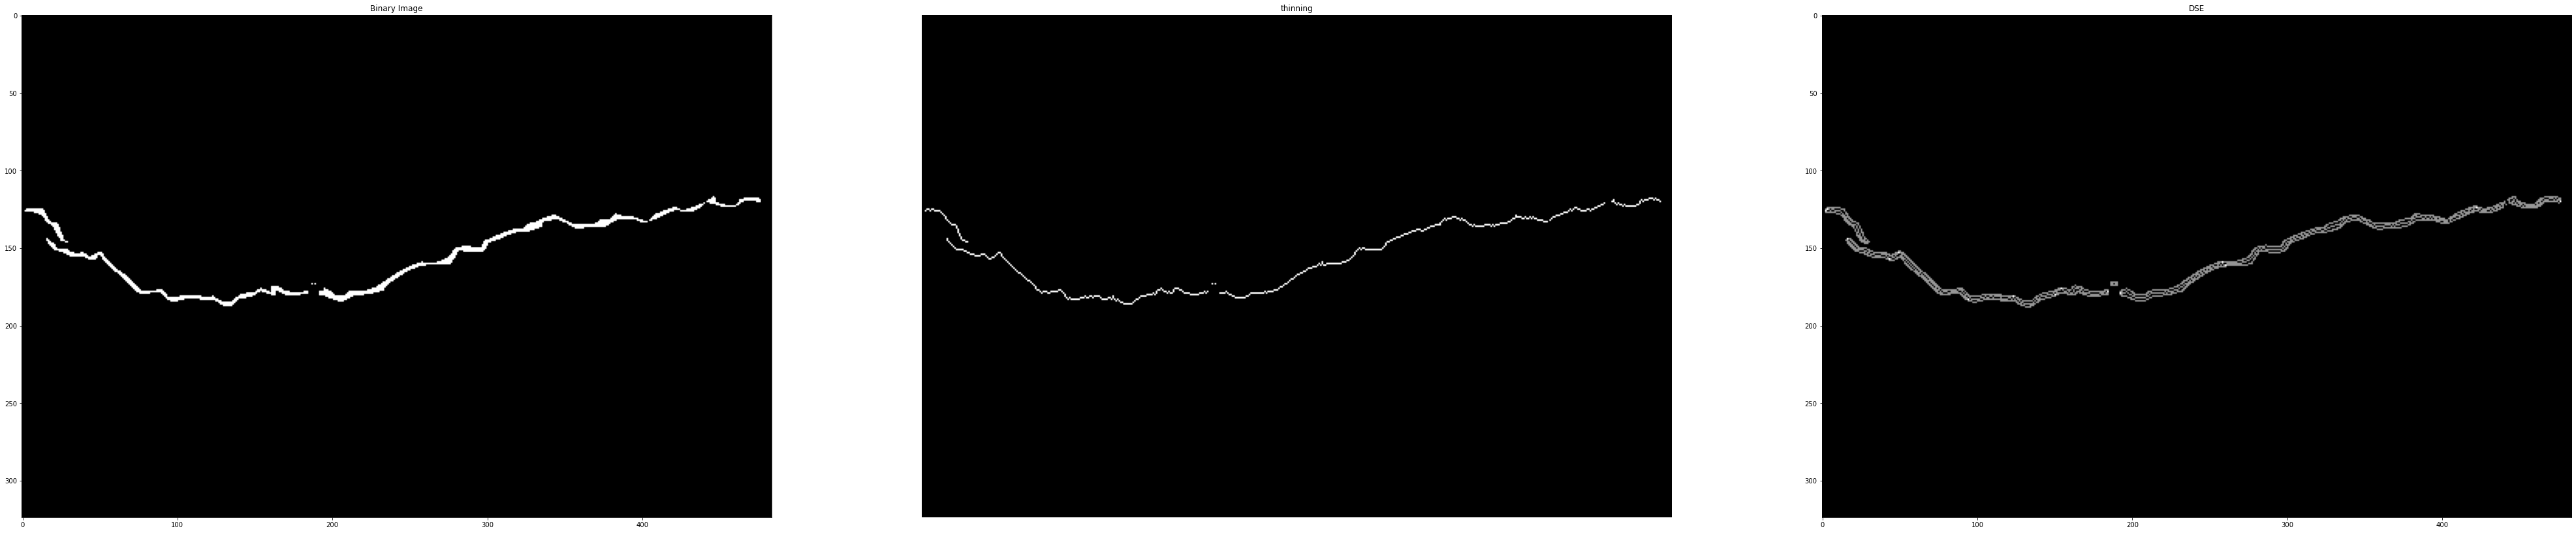

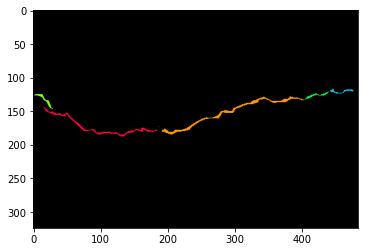

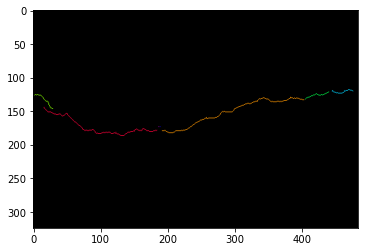

In [9]:
if __name__ == "__main__":
    folder_path = "./data/field_data"
    mask_paths = sorted(glob.glob(os.path.join(folder_path,'*png')))
    mask_files = []
    for path in mask_paths:
        mask = cv2.imread(path,cv2.IMREAD_UNCHANGED)
        mask_files.append(mask)


    # padding 
    padded_mask = []
    for mask in mask_files:
        pad_mask = np.pad(mask,((2,2),(2,2)),"constant")
        padded_mask.append(pad_mask)
    
    # Get initial skeleton
    
    # Cool representations using:
    # (1) crack500 [6]
    test_img = padded_mask[10]
    thin = morphology.thin(test_img)
    skel,dist = morphology.medial_axis(test_img,return_distance=True)
    skeleton_img, graph = skel_pruning_DSE(skel, dist, 20,return_graph=True)
    canny = feature.canny(test_img)
    r,c = np.nonzero(canny)
    ori_B = list(zip(r,c))

    # Remove intersection
    test_img_r,skeleton_img_r = remove_intersection(test_img,skeleton_img,ori_B,graph,verbose=True)
    canny = feature.canny(test_img_r > 0)
    r,c = np.nonzero(canny)
    B = list(zip(r,c))
    
    
    fig,ax = plt.subplots(nrows = 1, ncols = 3,figsize = (70,70), squeeze = True)
    ax[0].imshow(test_img_r,cmap="Greys_r")
    ax[0].set_title(f"Binary Image")

    ax[1].imshow(skeleton_img_r,cmap="Greys_r")
    ax[1].set_title(f"thinning")
    ax[1].axis("off")
    
    ax[2].imshow((canny + skeleton_img_r),cmap="Greys_r")
    ax[2].set_title(f"DSE")
    
    r,c = np.nonzero(skeleton_img_r)
    S = list(zip(r,c))
    print('skeleton points')
    
    num_labels_bin, labels_bin_img = cv2.connectedComponents(test_img_r)
    num_labels_skel, labels_skel_img = cv2.connectedComponents(skeleton_img_r)
    imshow_components(labels_bin_img)
    imshow_components(labels_skel_img)

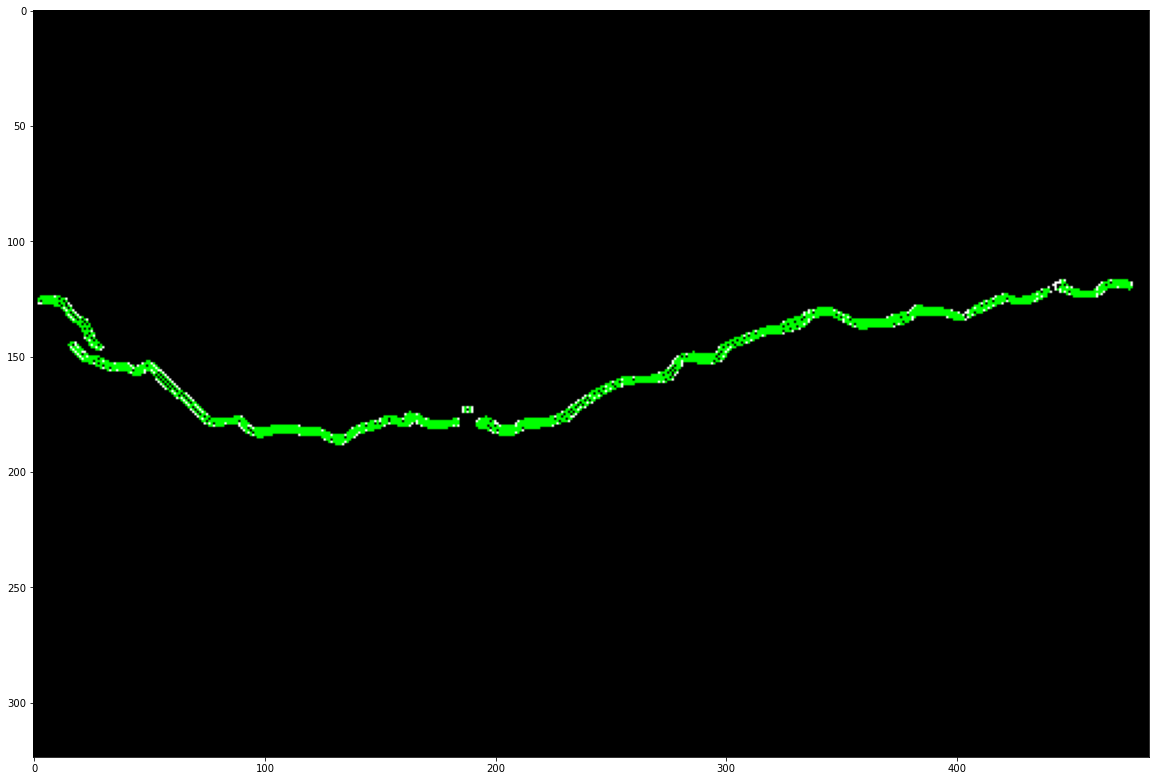

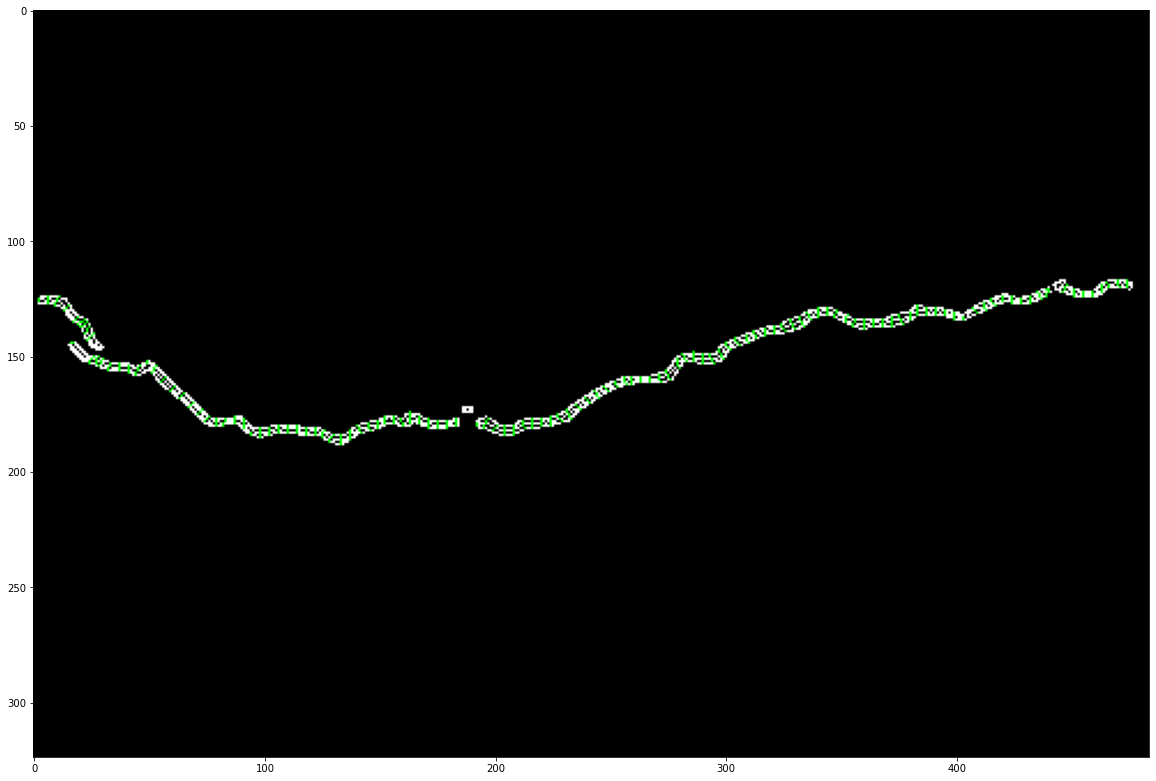

In [10]:
S_ordered = sorted(S, key = lambda x : x[1])
S_2 = [S_ordered[i] for i in range(0,len(S_ordered),1)]
poi = [(94,533)]
distance,distance_img = get_width(S_2,dist,test_img_r,skeleton_img_r,canny,ori_B,verbose=False,visualize=True)
S_2 = [S_ordered[i] for i in range(0,len(S_ordered),4)]
distance,distance_img = get_width(S_2,dist,test_img_r,skeleton_img_r,canny,ori_B,verbose=False,visualize=True)
